# به نام خدا 

# فاز یک


In [45]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.transform import resize
from skimage.util import img_as_ubyte

In [54]:


# تنظیمات مسیر و پارامترها
dataset_path = "train"
output_dir = "output_phase1"  # پوشه جدید برای ذخیره خروجی‌ها
os.makedirs(output_dir, exist_ok=True)  # ایجاد پوشه اگر وجود نداشته باشد

output_csv = os.path.join(output_dir, "image_features_10.csv")  # ذخیره در پوشه خروجی
classes = ["beach", "dense_residential", "desert", "forest", "intersection", "sea_ice"]

# پارامترهای پردازش تصویر
radius = 2
n_points = 16
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

def extract_10_features(image):
    """استخراج دقیقاً 10 ویژگی از تصویر ورودی"""
    # تغییر اندازه تصویر
    image = resize(image, (128, 128), anti_aliasing=True)
    
    # 1. میانگین Hue از فضای HSV
    hsv = rgb2hsv(image)
    mean_h = np.mean(hsv[:, :, 0])
    
    # 2. میانگین کانال سبز (اصلاح شده)
    green_mean = np.mean(image[:, :, 1])  # میانگین مستقیم کانال سبز
    
    # 3. ویژگی بافت LBP (اصلاح شده)
    gray_image = rgb2gray(image)
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_hist = np.histogram(lbp, bins=n_points+2, range=(0, n_points+2))[0]
    lbp_energy = np.sum(lbp_hist**2)  # استفاده از انرژی به جای میانگین
    
    # 4. میانگین ویژگی‌های HOG
    hog_features = hog(gray_image, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=False)
    hog_mean = np.mean(hog_features)
    
    # 5. کنتراست GLCM
    gray_image_ubyte = img_as_ubyte(gray_image)
    glcm = graycomatrix(gray_image_ubyte, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    
    # 6. تراکم لبه‌ها
    sobel_x = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edge_density = np.mean(edge_magnitude > 10)
    
    # 7. آنتروپی تصویر
    hist = np.histogram(gray_image, bins=256)[0]
    hist_normalized = hist / np.sum(hist)
    entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-10))
    
    # 8. نسبت آبی به سبز
    blue_green_ratio = np.mean(image[:, :, 2]) / (np.mean(image[:, :, 1]) + 1e-5)
    
    # 9. میانگین روشنایی (LAB)
    lab = rgb2lab(image)
    lightness_mean = np.mean(lab[:, :, 0])
    
    # 10. تعداد نقاط کلیدی SIFT
    sift = cv2.SIFT_create()
    keypoints = sift.detect((gray_image * 255).astype(np.uint8), None)
    sift_keypoints = len(keypoints) if keypoints is not None else 0
    
    return [
        mean_h, green_mean, lbp_energy, hog_mean, contrast,
        edge_density, entropy, blue_green_ratio, lightness_mean, sift_keypoints
    ]

def process_image(image_path):
    """پردازش هر تصویر و استخراج ویژگی‌ها"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ خطا در خواندن تصویر: {image_path}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return extract_10_features(image)
    except Exception as e:
        print(f"❌ خطا در پردازش {image_path}: {str(e)}")
        return None

# نام ویژگی‌ها (اصلاح شده)
feature_names = [
    "hsv_h_mean", "green_mean", "lbp_energy", "hog_mean", 
    "glcm_contrast", "edge_density", "entropy", 
    "blue_green_ratio", "lightness_mean", "sift_keypoints"
]

# پردازش تمام تصاویر
data = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ پوشه کلاس {class_name} وجود ندارد!")
        continue
    
    print(f"🔍 پردازش تصاویر کلاس {class_name}...")
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        features = process_image(img_path)
        
        if features is not None:
            data.append({
                "class": class_name,
                "filename": img_file,
                **dict(zip(feature_names, features))
            })

# ذخیره نتایج
if data:
    df = pd.DataFrame(data)
    try:
        df.to_csv(output_csv, index=False)
        print(f"\n✅ نتایج با موفقیت در {output_csv} ذخیره شد.")
        print(f"📊 تعداد تصاویر پردازش شده: {len(df)}")
        print(f"🔢 تعداد ویژگی‌های استخراج شده: {len(feature_names)}")
    except Exception as e:
        print(f"\n❌ خطا در ذخیره فایل: {str(e)}")
else:
    print("\n❌ هیچ تصویری پردازش نشد!")

🔍 پردازش تصاویر کلاس beach...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\skimage\feature\texture.py:385: UserWarning:

Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.



🔍 پردازش تصاویر کلاس dense_residential...
🔍 پردازش تصاویر کلاس desert...
🔍 پردازش تصاویر کلاس forest...
🔍 پردازش تصاویر کلاس intersection...
🔍 پردازش تصاویر کلاس sea_ice...

✅ نتایج با موفقیت در output_phase1\image_features_10.csv ذخیره شد.
📊 تعداد تصاویر پردازش شده: 3600
🔢 تعداد ویژگی‌های استخراج شده: 10


# فاز دو

In [66]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

فاز دو: انتخاب 4 ویژگی با کمترین همبستگی


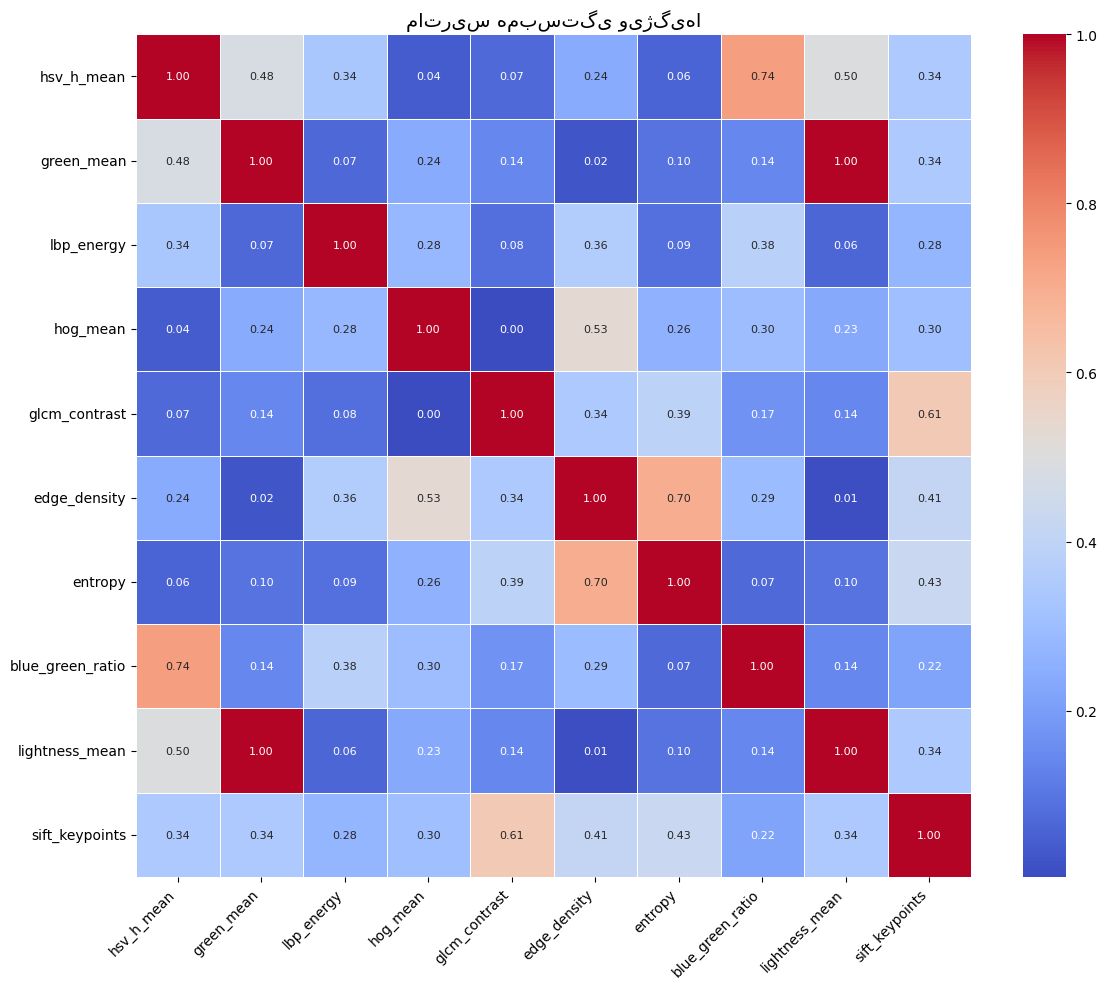


ویژگی‌های انتخاب شده:
1. lbp_energy
2. glcm_contrast
3. entropy
4. hog_mean

نتایج در پوشه 'output_phase2' ذخیره شد.


In [67]:

def select_low_correlation_features(df, n_features=4):
    """
    انتخاب n ویژگی با کمترین همبستگی و نمایش ماتریس همبستگی به صورت گرافیکی
    :param df: دیتافریم ورودی
    :param n_features: تعداد ویژگی‌های مورد نیاز
    :return: لیست ویژگی‌های انتخاب شده
    """
    # جداسازی ویژگی‌های عددی (به جز class و filename)
    numeric_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['class', 'filename'], errors='ignore')
    
    # محاسبه ماتریس همبستگی
    corr_matrix = numeric_features.corr().abs()
    
    # نمایش ماتریس همبستگی به صورت گرافیکی
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                cbar=True, linewidths=0.5, annot_kws={"size": 8})
    plt.title("ماتریس همبستگی ویژگی‌ها", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # محاسبه میانگین همبستگی هر ویژگی با سایرین
    mean_corr = corr_matrix.mean().sort_values()
    
    # انتخاب 4 ویژگی با کمترین میانگین همبستگی
    selected_features = mean_corr.head(n_features).index.tolist()
    
    return selected_features

if __name__ == "__main__":
    try:
        # ایجاد پوشه خروجی
        output_dir = "output_phase2"
        os.makedirs(output_dir, exist_ok=True)
        
        # خواندن داده‌های فاز یک
        df = pd.read_csv("output_phase1/image_features_10.csv")
        
        print("="*50)
        print("فاز دو: انتخاب 4 ویژگی با کمترین همبستگی")
        print("="*50)
        
        # انتخاب ویژگی‌ها
        best_features = select_low_correlation_features(df, 4)
        
        # ذخیره نتایج
        result_df = df[['class', 'filename'] + best_features]
        result_df.to_csv(os.path.join(output_dir, "selected_features.csv"), index=False)
        
        print("\nویژگی‌های انتخاب شده:")
        for i, feat in enumerate(best_features, 1):
            print(f"{i}. {feat}")
            
        print(f"\nنتایج در پوشه '{output_dir}' ذخیره شد.")
        
    except FileNotFoundError:
        print("\nخطا: فایل image_features_10.csv یافت نشد. لطفاً ابتدا فاز یک را اجرا کنید.")
    except Exception as e:
        print(f"\nخطا: {str(e)}")

# فاز سه

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors



In [17]:
# --- 1. بارگذاری داده‌ها و پیش‌پردازش ---
def load_data():
    try:
        data = pd.read_csv('selected_features.csv')
        features = data.drop(['class', 'filename'], axis=1)
        return data, features
    except FileNotFoundError:
        print("❌ فایل 'selected_features.csv' پیدا نشد.")
        exit(1)

# --- 2. نرمال‌سازی داده‌ها ---
def normalize_data(features):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    joblib.dump(scaler, 'scaler.joblib')
    return X_scaled

# --- 3. توابع ارزیابی خوشه‌بندی ---
def evaluate_clustering(X, labels, algorithm_name):
    if len(set(labels)) < 2:
        print(f"⚠️ تعداد خوشه‌های معتبر برای {algorithm_name} کمتر از ۲ است")
        return
    
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    print(f"\nارزیابی {algorithm_name}:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    return silhouette, db_index, ch_score

# --- 4. KMeans با بهینه‌سازی تعداد خوشه‌ها ---
def optimize_kmeans(X):
    print("\n--- بهینه‌سازی KMeans ---")
    k_range = range(2, 7)  # محدوده 2 تا 6 خوشه
    
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        print(f"K={k} | Silhouette={score:.4f}")
    
    # انتخاب ثابت K=6
    best_k = 6
    best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    best_labels = best_kmeans.fit_predict(X)
    
    # رسم نمودار Elbow Method
    distortions = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method (Selected K={best_k})')
    plt.savefig('kmeans_elbow.png')
    plt.close()
    
    # ذخیره مدل
    joblib.dump(best_kmeans, 'best_kmeans_model.joblib')
    
    return best_kmeans, best_labels

# --- 5. DBSCAN با بهینه‌سازی پارامترها ---
def optimize_dbscan(X):
    print("\n--- بهینه‌سازی DBSCAN ---")
    
    # تعیین eps مناسب با استفاده از KNN
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)
    distances = np.sort(distances[:, -1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel('Epsilon')
    plt.title('KNN Distance for Epsilon Estimation')
    plt.savefig('dbscan_epsilon.png')
    plt.close()
    
    # جستجوی ترکیب بهینه پارامترها
    best_score = -1
    best_dbscan = None
    
    for eps in np.arange(0.2, 1.0, 0.1):
        for min_samples in [3, 5, 7]:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = dbscan.fit_predict(X)
            
            if len(set(labels)) > 1:  # حداقل دو خوشه
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_dbscan = dbscan
    
    if best_dbscan:
        best_labels = best_dbscan.fit_predict(X)
        print(f"بهترین پارامترها: eps={best_dbscan.eps}, min_samples={best_dbscan.min_samples}")
        return best_dbscan, best_labels
    else:
        print("❌ DBSCAN نتوانست خوشه‌های معتبری ایجاد کند")
        return None, None

# --- 6. Agglomerative Clustering با بهینه‌سازی ---
def optimize_agglomerative(X):
    print("\n--- بهینه‌سازی Agglomerative Clustering ---")
    best_score = -1
    best_model = None
    
    linkages = ['ward', 'complete', 'average', 'single']
    n_clusters_range = range(2, 7)  # محدوده کمتر برای اجرای سریع‌تر
    
    for linkage in linkages:
        for n_clusters in n_clusters_range:
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            labels = agg.fit_predict(X)
            
            if len(set(labels)) > 1:
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_model = agg
    
    if best_model:
        best_labels = best_model.fit_predict(X)
        print(f"بهترین پارامترها: n_clusters={best_model.n_clusters}, linkage={best_model.linkage}")
        return best_model, best_labels
    else:
        print("❌ Agglomerative Clustering نتوانست خوشه‌های معتبری ایجاد کند")
        return None, None

# --- 7. MeanShift با بهینه‌سازی ---
def optimize_meanshift(X):
    print("\n--- بهینه‌سازی MeanShift ---")
    best_score = -1
    best_model = None
    
    # نمونه‌گیری تصادفی برای کاهش حجم داده
    if X.shape[0] > 1000:
        X_sampled = X[np.random.choice(X.shape[0], 1000, replace=False), :]
    else:
        X_sampled = X
    
    bandwidths = np.arange(0.5, 2.1, 0.5)  # گام بزرگتر برای اجرای سریع‌تر
    
    for bandwidth in bandwidths:
        try:
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1, cluster_all=False)
            labels = ms.fit_predict(X_sampled)
            
            if len(set(labels)) > 1:
                score = silhouette_score(X_sampled, labels)
                if score > best_score:
                    best_score = score
                    best_model = ms
        except Exception as e:
            print(f"خطا در bandwidth={bandwidth}: {str(e)}")
            continue
    
    if best_model:
        # اجرای نهایی روی کل داده‌ها
        best_labels = best_model.fit_predict(X)
        print(f"بهترین bandwidth: {best_model.bandwidth:.2f}")
        return best_model, best_labels
    else:
        print("❌ MeanShift نتوانست خوشه‌های معتبری ایجاد کند")
        return None, None

# --- 8. Spectral Clustering ---
def optimize_spectral(X):
    print("\n--- بهینه‌سازی Spectral Clustering ---")
    best_score = -1
    best_model = None
    
    n_clusters_range = range(2, 7)  # محدوده کمتر برای اجرای سریع‌تر
    
    for n_clusters in n_clusters_range:
        sc = SpectralClustering(n_clusters=n_clusters, 
                              affinity='nearest_neighbors',
                              random_state=42,
                              n_jobs=-1)
        labels = sc.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_model = sc
    
    if best_model:
        best_labels = best_model.fit_predict(X)
        print(f"بهترین n_clusters: {best_model.n_clusters}")
        return best_model, best_labels
    else:
        print("❌ Spectral Clustering نتوانست خوشه‌های معتبری ایجاد کند")
        return None, None

# --- 9. Gaussian Mixture Models ---
def optimize_gmm(X):
    print("\n--- بهینه‌سازی Gaussian Mixture Models ---")
    best_score = -1
    best_model = None
    
    n_components_range = range(2, 7)  # محدوده کمتر برای اجرای سریع‌تر
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, 
                            random_state=42,
                            init_params='kmeans')
        labels = gmm.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_model = gmm
    
    if best_model:
        best_labels = best_model.fit_predict(X)
        print(f"بهترین n_components: {best_model.n_components}")
        return best_model, best_labels
    else:
        print("❌ GMM نتوانست خوشه‌های معتبری ایجاد کند")
        return None, None

# --- 10. رسم Heatmap برای ویژگی‌های هر خوشه ---
def plot_cluster_heatmaps(data, cluster_columns, features):
    for col in cluster_columns:
        if col in data.columns:
            plt.figure(figsize=(12, 6))
            cluster_means = data.groupby(col)[features].mean()
            sns.heatmap(cluster_means.T, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title(f'میانگین ویژگی‌ها برای خوشه‌های {col}')
            plt.tight_layout()
            plt.savefig(f'heatmap_{col}.png')
            plt.close()

# --- اجرای اصلی برنامه ---
if __name__ == "__main__":
    # بارگذاری داده‌ها
    data, features = load_data()
    X = normalize_data(features)
    
    # لیست مدل‌ها و برچسب‌ها
    models = []
    labels_cols = []
    
    try:
        # اجرای الگوریتم‌های خوشه‌بندی
        kmeans_model, kmeans_labels = optimize_kmeans(X)
        if kmeans_model:
            data['kmeans_cluster'] = kmeans_labels
            evaluate_clustering(X, kmeans_labels, "KMeans")
            joblib.dump(kmeans_model, 'kmeans_model.joblib')
            models.append(('KMeans', kmeans_model))
            labels_cols.append('kmeans_cluster')
        
        dbscan_model, dbscan_labels = optimize_dbscan(X)
        if dbscan_model is not None:
            data['dbscan_cluster'] = dbscan_labels
            evaluate_clustering(X, dbscan_labels, "DBSCAN")
            joblib.dump(dbscan_model, 'dbscan_model.joblib')
            models.append(('DBSCAN', dbscan_model))
            labels_cols.append('dbscan_cluster')
        
        agg_model, agg_labels = optimize_agglomerative(X)
        if agg_model:
            data['agg_cluster'] = agg_labels
            evaluate_clustering(X, agg_labels, "Agglomerative")
            joblib.dump(agg_model, 'agg_model.joblib')
            models.append(('Agglomerative', agg_model))
            labels_cols.append('agg_cluster')
        
        ms_model, ms_labels = optimize_meanshift(X)
        if ms_model:
            data['meanshift_cluster'] = ms_labels
            evaluate_clustering(X, ms_labels, "MeanShift")
            joblib.dump(ms_model, 'meanshift_model.joblib')
            models.append(('MeanShift', ms_model))
            labels_cols.append('meanshift_cluster')
        
        sc_model, sc_labels = optimize_spectral(X)
        if sc_model:
            data['spectral_cluster'] = sc_labels
            evaluate_clustering(X, sc_labels, "Spectral Clustering")
            joblib.dump(sc_model, 'spectral_model.joblib')
            models.append(('Spectral', sc_model))
            labels_cols.append('spectral_cluster')
        
        gmm_model, gmm_labels = optimize_gmm(X)
        if gmm_model:
            data['gmm_cluster'] = gmm_labels
            evaluate_clustering(X, gmm_labels, "Gaussian Mixture Model")
            joblib.dump(gmm_model, 'gmm_model.joblib')
            models.append(('GMM', gmm_model))
            labels_cols.append('gmm_cluster')
        
        # ذخیره نتایج
        data.to_csv('clustering_results.csv', index=False)
        
        # رسم heatmap برای هر روش خوشه‌بندی
        plot_cluster_heatmaps(data, labels_cols, features.columns)
        
        print("\n✅ خوشه‌بندی با موفقیت انجام شد و نتایج ذخیره گردید.")
    
    except Exception as e:
        print(f"\n❌ خطا در اجرای خوشه‌بندی: {str(e)}")
        # ذخیره نتایج تا اینجا
        if 'data' in locals():
            data.to_csv('clustering_results_partial.csv', index=False)
        raise


--- بهینه‌سازی KMeans ---
K=2 | Silhouette=0.2694
K=3 | Silhouette=0.2858
K=4 | Silhouette=0.2864
K=5 | Silhouette=0.2741
K=6 | Silhouette=0.2631

ارزیابی KMeans:
Silhouette Score: 0.2631
Davies-Bouldin Index: 1.0895
Calinski-Harabasz Score: 1285.0535

--- بهینه‌سازی DBSCAN ---
بهترین پارامترها: eps=0.9000000000000001, min_samples=5

ارزیابی DBSCAN:
Silhouette Score: 0.4764
Davies-Bouldin Index: 2.1767
Calinski-Harabasz Score: 71.6542

--- بهینه‌سازی Agglomerative Clustering ---
بهترین پارامترها: n_clusters=2, linkage=single

ارزیابی Agglomerative:
Silhouette Score: 0.6812
Davies-Bouldin Index: 0.2239
Calinski-Harabasz Score: 15.0362

--- بهینه‌سازی MeanShift ---
بهترین bandwidth: 2.00

ارزیابی MeanShift:
Silhouette Score: 0.1953
Davies-Bouldin Index: 2.0656
Calinski-Harabasz Score: 154.1049

--- بهینه‌سازی Spectral Clustering ---
بهترین n_clusters: 2

ارزیابی Spectral Clustering:
Silhouette Score: 0.5516
Davies-Bouldin Index: 0.7639
Calinski-Harabasz Score: 909.6122

--- بهینه‌سازی G

# فاز چهار


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:


# --- 1. بارگذاری داده‌ها و آماده‌سازی ---
def load_data():
    try:
        data = pd.read_csv('clustering_results.csv')
        print("✅ داده‌های خوشه‌بندی با موفقیت بارگذاری شدند")
        
        # استخراج ویژگی‌ها (بدون ستون‌های غیر عددی)
        features = data.select_dtypes(include=[np.number])
        features = features.drop(columns=[col for col in features.columns if 'cluster' in col], errors='ignore')
        
        # نرمال‌سازی داده‌ها
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        return data, features_scaled
    except Exception as e:
        print(f"❌ خطا در بارگذاری داده‌ها: {str(e)}")
        exit(1)

# --- 2. تابع رسم PCA با seaborn و plotly ---
def plot_pca_analysis(X, labels, algorithm_name):
    # کاهش ابعاد با PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    # ایجاد دیتافریم برای تجسم
    df_pca = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Cluster': labels.astype(str)
    })
    
    # رسم با seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', 
                    palette='viridis', s=60, alpha=0.8)
    plt.title(f'PCA Visualization - {algorithm_name}', fontsize=14)
    plt.xlabel(f'PC1 (Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'pca_{algorithm_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # رسم نمودار تعاملی با plotly
    fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster',
                     title=f'Interactive PCA - {algorithm_name}',
                     hover_data={'Cluster': True},
                     color_discrete_sequence=px.colors.qualitative.Vivid)
    fig.write_html(f"interactive_pca_{algorithm_name.lower()}.html")

# --- 3. تابع رسم t-SNE با seaborn و plotly ---
def plot_tsne_analysis(X, labels, algorithm_name):
    # کاهش ابعاد با t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter_without_progress=1000, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    # ایجاد دیتافریم برای تجسم
    df_tsne = pd.DataFrame({
        't-SNE1': X_tsne[:, 0],
        't-SNE2': X_tsne[:, 1],
        'Cluster': labels.astype(str)
    })
    
    # رسم با seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_tsne, x='t-SNE1', y='t-SNE2', hue='Cluster',
                    palette='viridis', s=60, alpha=0.8)
    plt.title(f't-SNE Visualization - {algorithm_name}', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'tsne_{algorithm_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # رسم نمودار تعاملی با plotly
    fig = px.scatter(df_tsne, x='t-SNE1', y='t-SNE2', color='Cluster',
                     title=f'Interactive t-SNE - {algorithm_name}',
                     hover_data={'Cluster': True},
                     color_discrete_sequence=px.colors.qualitative.Plotly)
    fig.write_html(f"interactive_tsne_{algorithm_name.lower()}.html")


# --- 4. تابع رسم UMAP با seaborn و plotly ---
def plot_umap_analysis(X, labels, algorithm_name):
    # کاهش ابعاد با UMAP
    umap = UMAP(n_components=2, random_state=42)
    X_umap = umap.fit_transform(X)
    
    # ایجاد دیتافریم برای تجسم
    df_umap = pd.DataFrame({
        'UMAP1': X_umap[:, 0],
        'UMAP2': X_umap[:, 1],
        'Cluster': labels.astype(str)
    })
    
    # رسم با seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Cluster',
                    palette='viridis', s=60, alpha=0.8)
    plt.title(f'UMAP Visualization - {algorithm_name}', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'umap_{algorithm_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # رسم نمودار تعاملی با plotly
    fig = px.scatter(df_umap, x='UMAP1', y='UMAP2', color='Cluster',
                     title=f'Interactive UMAP - {algorithm_name}',
                     hover_data={'Cluster': True},
                     color_discrete_sequence=px.colors.qualitative.Dark24)
    fig.write_html(f"interactive_umap_{algorithm_name.lower()}.html")

# --- 5. تابع اصلی برای تجسم تمام روش‌ها ---
def visualize_clustering_results(data, X):
    # لیست الگوریتم‌های خوشه‌بندی موجود
    cluster_columns = [col for col in data.columns if 'cluster' in col.lower()]
    
    if not cluster_columns:
        print("⚠️ هیچ ستون خوشه‌بندی در داده‌ها یافت نشد")
        return
    
    print(f"\n🔍 یافت شد {len(cluster_columns)} ستون خوشه‌بندی برای تجسم:")
    print(cluster_columns)
    
    for col in cluster_columns:
        algorithm_name = col.replace('_cluster', '').capitalize()
        labels = data[col]
        
        print(f"\n📊 در حال پردازش خوشه‌بندی {algorithm_name}...")
        
        # حذف نمونه‌های با برچسب نویز (برای DBSCAN)
        if -1 in labels.values:
            mask = labels != -1
            X_filtered = X[mask]
            labels_filtered = labels[mask]
            print(f"حذف {sum(~mask)} نمونه به عنوان نویز")
        else:
            X_filtered = X
            labels_filtered = labels
        
        # رسم نمودارها
        plot_pca_analysis(X_filtered, labels_filtered, algorithm_name)
        plot_tsne_analysis(X_filtered, labels_filtered, algorithm_name)
        plot_umap_analysis(X_filtered, labels_filtered, algorithm_name)

# --- 6. اجرای برنامه ---
if __name__ == "__main__":
    data, features_scaled = load_data()
    visualize_clustering_results(data, features_scaled)


✅ داده‌های خوشه‌بندی با موفقیت بارگذاری شدند

🔍 یافت شد 6 ستون خوشه‌بندی برای تجسم:
['kmeans_cluster', 'dbscan_cluster', 'agg_cluster', 'meanshift_cluster', 'spectral_cluster', 'gmm_cluster']

📊 در حال پردازش خوشه‌بندی Kmeans...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




📊 در حال پردازش خوشه‌بندی Dbscan...
حذف 63 نمونه به عنوان نویز


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




📊 در حال پردازش خوشه‌بندی Agg...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




📊 در حال پردازش خوشه‌بندی Meanshift...
حذف 1321 نمونه به عنوان نویز


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




📊 در حال پردازش خوشه‌بندی Spectral...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




📊 در حال پردازش خوشه‌بندی Gmm...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# فاز پنج


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score
from sklearn.cluster import KMeans


In [21]:
# --- 1. بارگذاری داده‌ها ---
data = pd.read_csv('clustering_results.csv')

# نمایش نام ستون‌ها
print("📄 نام ستون‌ها:")
print(data.columns.tolist())

# بررسی وجود ستون 'class'
if 'class' not in data.columns:
    print("❌ ستون 'class' وجود ندارد. ارزیابی نمی‌تواند انجام شود.")
    exit(1)

# --- 2. استخراج ویژگی‌ها ---
X = data.drop(columns=['filename', 'class'], errors='ignore')  # حذف ستون‌های غیرعددی

# --- 3. حذف داده‌های پرت با استفاده از IQR ---
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X_filtered = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]

# --- 4. نرمال‌سازی داده‌ها ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# --- 5. برچسب‌های واقعی ---
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(data['class'])

# --- 6. انتخاب بهترین خوشه‌بندی موجود ---
if 'kmeans_cluster' in data.columns:
    predicted_labels = data['kmeans_cluster'].loc[X_filtered.index]  # تطبیق با X_filtered
    method_name = 'KMeans'
elif 'meanshift_cluster' in data.columns:
    predicted_labels = data['meanshift_cluster'].loc[X_filtered.index]  # تطبیق با X_filtered
    method_name = 'MeanShift'
elif 'agg_cluster' in data.columns:
    predicted_labels = data['agg_cluster'].loc[X_filtered.index]  # تطبیق با X_filtered
    method_name = 'Agglomerative'
elif 'dbscan_cluster' in data.columns and len(set(data['dbscan_cluster'])) > 1:
    predicted_labels = data['dbscan_cluster'].loc[X_filtered.index]  # تطبیق با X_filtered
    method_name = 'DBSCAN'
else:
    # در صورت نبود ستون خوشه، از KMeans جدید استفاده می‌کنیم
    print("⚠️ ستون خوشه‌بندی معتبر پیدا نشد. اجرای مجدد KMeans...")
    kmeans = KMeans(n_clusters=6, random_state=42)  # تغییر به K=6
    predicted_labels = kmeans.fit_predict(X_scaled)
    method_name = 'KMeans (new)'

# --- 7. محاسبه معیارها ---
precision = precision_score(true_labels[:len(predicted_labels)], predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels[:len(predicted_labels)], predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels[:len(predicted_labels)], predicted_labels, average='weighted', zero_division=0)
silhouette = silhouette_score(X_scaled, predicted_labels)

# --- 8. نمایش نتایج ---
print(f"\n📊 نتایج ارزیابی برای الگوریتم {method_name}:")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Silhouette Score: {silhouette:.4f}")

# --- 9. تحلیل ---
print("\n🔎 تحلیل تفاوت معیارها:")
print("- Precision دقت پیش‌بینی نمونه‌های صحیح را نشان می‌دهد.")
print("- Recall توانایی مدل در پیدا کردن همه اعضای کلاس واقعی را اندازه می‌گیرد.")
print("- F1 Score میانگین هارمونیک Precision و Recall است که تعادلی بین آنها ایجاد می‌کند.")
print("- Silhouette Score مستقل از برچسب‌های واقعی است و فقط کیفیت خوشه‌بندی را از نظر فاصله داخلی و خارجی خوشه‌ها می‌سنجد.")
print("➕ Silhouette بالا نشان‌دهنده خوشه‌های خوب از نظر تفکیک ساختار داده است.")

📄 نام ستون‌ها:
['class', 'filename', 'hist_g_2', 'hist_g_3', 'hist_g_6', 'hist_b_0', 'glcm_correlation', 'kmeans_cluster', 'dbscan_cluster', 'agg_cluster', 'meanshift_cluster', 'spectral_cluster', 'gmm_cluster']

📊 نتایج ارزیابی برای الگوریتم KMeans:
✅ Precision: 0.0767
✅ Recall: 0.0801
✅ F1 Score: 0.0725
✅ Silhouette Score: 0.2228

🔎 تحلیل تفاوت معیارها:
- Precision دقت پیش‌بینی نمونه‌های صحیح را نشان می‌دهد.
- Recall توانایی مدل در پیدا کردن همه اعضای کلاس واقعی را اندازه می‌گیرد.
- F1 Score میانگین هارمونیک Precision و Recall است که تعادلی بین آنها ایجاد می‌کند.
- Silhouette Score مستقل از برچسب‌های واقعی است و فقط کیفیت خوشه‌بندی را از نظر فاصله داخلی و خارجی خوشه‌ها می‌سنجد.
➕ Silhouette بالا نشان‌دهنده خوشه‌های خوب از نظر تفکیک ساختار داده است.


# فاز شیش


In [22]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
import shutil
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from sklearn.preprocessing import StandardScaler


In [23]:

# تنظیمات مسیرها
test_dir = 'test'
output_dir = 'clustered_results'
kmeans_model_path = 'best_kmeans_model.joblib'
scaler_path = 'scaler.joblib'

# ویژگی‌های انتخابی از فاز 2
selected_features = ['hist_g_2', 'hist_g_3', 'hist_g_6', 'hist_b_0', 'glcm_correlation']

def extract_features(image):
    """استخراج 5 ویژگی کلیدی از تصویر"""
    try:
        image = resize(image, (128, 128), anti_aliasing=True)
        R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        
        # هیستوگرام رنگ‌ها
        hist_g = np.histogram(G, bins=8, range=(0, 1))[0]
        hist_b = np.histogram(B, bins=8, range=(0, 1))[0]
        
        # ویژگی‌های بافت
        gray_image = rgb2gray(image)
        gray_image_ubyte = img_as_ubyte(gray_image)
        glcm = graycomatrix(gray_image_ubyte, distances=[1], angles=[0], 
                          levels=256, symmetric=True, normed=True)
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        
        return {
            'hist_g_2': hist_g[2],
            'hist_g_3': hist_g[3],
            'hist_g_6': hist_g[6],
            'hist_b_0': hist_b[0],
            'glcm_correlation': correlation
        }
    except Exception as e:
        print(f"خطا در استخراج ویژگی: {str(e)}")
        return None

def process_and_cluster_images():
    """پردازش تصاویر و خوشه‌بندی"""
    # 1. استخراج ویژگی‌ها از تمام تصاویر
    image_data = []
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            try:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                features = extract_features(img_rgb)
                if features:
                    image_data.append({
                        'original_path': img_path,
                        'original_class': class_name,
                        **features
                    })
            except Exception as e:
                print(f"خطا در پردازش {img_path}: {str(e)}")
    
    if not image_data:
        raise ValueError("هیچ تصویری برای پردازش یافت نشد!")
    
    df = pd.DataFrame(image_data)
    
    # 2. بارگذاری مدل و اسکیلر
    scaler = joblib.load(scaler_path)
    kmeans = joblib.load(kmeans_model_path)
    
    # 3. نرمال‌سازی و پیش‌بینی خوشه
    X = df[selected_features]
    df['cluster'] = kmeans.predict(scaler.transform(X))
    
    # 4. ذخیره تصاویر در پوشه‌های خوشه
    os.makedirs(output_dir, exist_ok=True)
    for cluster_num in df['cluster'].unique():
        cluster_dir = os.path.join(output_dir, f"cluster_{cluster_num}")
        os.makedirs(cluster_dir, exist_ok=True)
        
        # کپی تصاویر به پوشه خوشه مربوطه
        cluster_images = df[df['cluster'] == cluster_num]['original_path']
        for img_path in cluster_images:
            shutil.copy(img_path, cluster_dir)
    
    # 5. ذخیره اطلاعات متادیتا
    df.to_csv(os.path.join(output_dir, 'clustering_results.csv'), index=False)
    
    print(f"✅ تصاویر با موفقیت در پوشه {output_dir} سازماندهی شدند")
    print(f"✅ تعداد خوشه‌ها: {len(df['cluster'].unique())}")
    print(f"✅ تعداد کل تصاویر پردازش شده: {len(df)}")

if __name__ == "__main__":
    process_and_cluster_images()

✅ تصاویر با موفقیت در پوشه clustered_results سازماندهی شدند
✅ تعداد خوشه‌ها: 6
✅ تعداد کل تصاویر پردازش شده: 600
